In [31]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
L = 32
Directory = f"data/L_{L}"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [21]:
times = [i for i in range(1,64)]
perm = np.random.permutation(times)
train_times = perm[:int(0.8*63)]
test_times = perm[int(0.8*63):]

In [22]:
#init train ds
path_data = Directory+f'/input_ds_for_simple_nn_T{train_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
train_ds = nc_init['sample'][:].filled()

for t in train_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    train_ds = np.concatenate((train_ds, time_ds), axis=0)

In [85]:
#init test ds
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()

for t in test_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    test_ds = np.concatenate((test_ds, time_ds), axis=0)

In [29]:
# split train and test ds in input-output datasets
input_train, output_train, input_val, output_val = train_ds[:,:len_in], train_ds[:,len_in:], test_ds[:,:len_in], test_ds[:,len_in:]
input_train.shape

(12800, 2256)

## Define the model

In [32]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.1, drop_prob2=0.2, drop_prob3=0.3, hidden_size1=512, hidden_size2=256, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [33]:
learning_rate = 0.001
batch_size = 32
nb_epochs = 100
losses=[]

In [34]:
model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# convert numpy array to torch tensor
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()

In [35]:
# train the model
model.train()


for epoch in trange(nb_epochs, leave=False):
    tot_losses=0
    indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
    for i_batch in indexes_arr:
        input_batch = input[i_batch,:]
        output_batch = output[i_batch,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss = F.mse_loss(output_pred, output_batch, reduction='mean')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    losses.append(tot_losses/(input_train.shape[0]//batch_size))
    if (epoch+1)%5==0 or epoch==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/(input_train.shape[0]//batch_size)))

  1%|          | 1/100 [00:05<09:39,  5.85s/it]

Epoch [1/100], Loss: 0.012789


  5%|▌         | 5/100 [01:22<26:21, 16.64s/it]

Epoch [5/100], Loss: 0.003853


 10%|█         | 10/100 [03:09<30:41, 20.46s/it]

Epoch [10/100], Loss: 0.003746


 15%|█▌        | 15/100 [04:56<30:17, 21.38s/it]

Epoch [15/100], Loss: 0.003293


 20%|██        | 20/100 [06:43<28:33, 21.42s/it]

Epoch [20/100], Loss: 0.003838


 25%|██▌       | 25/100 [08:32<27:05, 21.67s/it]

Epoch [25/100], Loss: 0.003219


 30%|███       | 30/100 [10:22<25:34, 21.93s/it]

Epoch [30/100], Loss: 0.003193


 35%|███▌      | 35/100 [12:12<23:55, 22.08s/it]

Epoch [35/100], Loss: 0.003354


 40%|████      | 40/100 [14:06<22:46, 22.78s/it]

Epoch [40/100], Loss: 0.003607


 45%|████▌     | 45/100 [15:58<20:29, 22.35s/it]

Epoch [45/100], Loss: 0.003442


 48%|████▊     | 48/100 [17:06<19:27, 22.45s/it]

KeyboardInterrupt: 

In [36]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
predictions= torch.zeros(output_test.shape)
tot_losses=0

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='mean')

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.006391


In [45]:
print(output_pred[:5,:10])
print(output_test[:5,:10])

tensor([[-1.5468e-04,  2.8410e-03,  4.6770e-01,  4.6603e-01,  4.6416e-01,
          4.6217e-01,  4.6021e-01,  4.5804e-01,  4.5590e-01,  4.5370e-01],
        [-1.8112e-04,  2.2541e-03,  4.6366e-01,  4.6241e-01,  4.6098e-01,
          4.5942e-01,  4.5789e-01,  4.5613e-01,  4.5443e-01,  4.5266e-01],
        [ 7.7666e-06,  2.6247e-03,  3.6127e-01,  3.5882e-01,  3.5626e-01,
          3.5368e-01,  3.5103e-01,  3.4834e-01,  3.4562e-01,  3.4288e-01],
        [ 2.1549e-04,  1.0293e-03,  3.1397e-01,  3.1236e-01,  3.1075e-01,
          3.0908e-01,  3.0732e-01,  3.0556e-01,  3.0380e-01,  3.0202e-01],
        [ 3.1112e-04,  8.0706e-04,  5.9696e-02,  5.7651e-02,  5.5677e-02,
          5.3784e-02,  5.1843e-02,  5.0090e-02,  4.8317e-02,  4.6563e-02]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0000, -0.0012,  0.5635,  0.5645,  0.5654,  0.5662,  0.5668,  0.5672,
          0.5675,  0.5679],
        [ 0.0000,  0.0049,  0.5024,  0.4995,  0.4965,  0.4935,  0.4905,  0.4874,
          0.4841,  0.4808],
    

In [46]:
torch.save(model.state_dict(), 'explo/simple_dnn')

## Use previous models

In [47]:
model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load('explo/models/simple_dnn3'))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): Linear(in_features=2256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [48]:
# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
tot_losses=0

model_load.eval()
# prediction
output_pred = model_load(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='mean')

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.006391


In [81]:
output_test.shape

16

t = 55


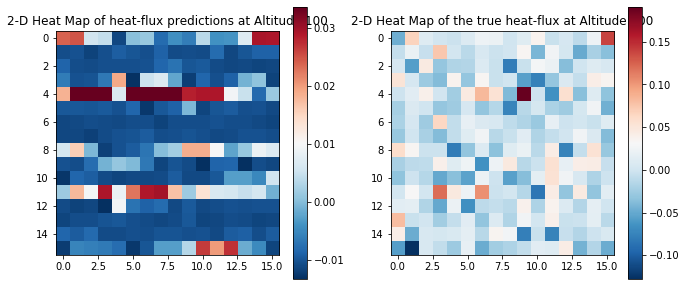

In [89]:
t = 0
z=100
largeur = int(512/L)
pred_ds = output_pred[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()
true_ds = output_test[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()

print('t =',test_times[t])
utils.plot_output(pred_ds,true_ds,L,z,color='RdBu_r')

## Check coherence

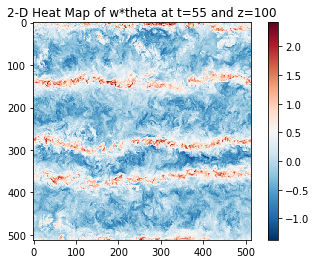

In [96]:
nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/wxy{z//2}_T{test_times[t]}.nc")
w_arr = nc_init[f'wxy{z//2}'][:].filled()[0,1,:,:]

nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/thetaxy{z//2}_T{test_times[t]}.nc")
theta_arr = nc_init[f'thetaxy{z//2}'][:].filled()[0,1,:,:]

wtheta = w_arr*theta_arr

im = plt.imshow(wtheta , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im)
plt.title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()

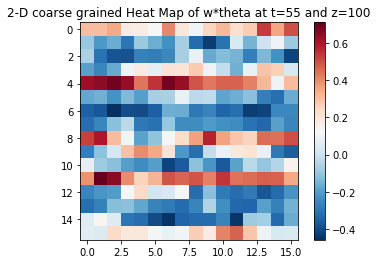

In [97]:
im = plt.imshow(utils.coarse_array(wtheta.reshape(1,1,512,512),L).reshape(16,16) , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im)
plt.title(f"2-D coarse grained Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()